## Heatmaps generators

In [29]:
from PIL import Image
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from utils import crop_and_mask
from obb import OBB
import cv2
from error_analysor import convert_to_world_point, compute_length, compute_segmentation_error
import sys
sys.path.append("/root/simon/volume_estimation/")
from data_loader import DataGenerator
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python2.7/dist-packages/scipy/cluster/vq.py:78: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _vq
/usr/local/lib/python2.7/dist-packages/scipy/cluster/hierarchy.py:178: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _hierarchy, _optimal_leaf_ordering


In [3]:
%matplotlib notebook

### 1 - Gound truths

In [4]:
left_path = '/root/data/blender_test/Image0028_L.png'
right_path = '/root/data/blender_test/Image0028_R.png'
ground_truth_depth_path = '/root/data/blender_test/true_depth.npy'

In [5]:
# get ground truth mask + segmentation
mask = crop_and_mask(Image.open(left_path))
ground_truth_depth = np.load(ground_truth_depth_path)
mdepth = ground_truth_depth * mask
x, y = np.nonzero(mdepth>10)
for (i,j) in zip(x,y):
    mask[i,j] = 0
mdepth = ground_truth_depth * mask

<IPython.core.display.Javascript object>


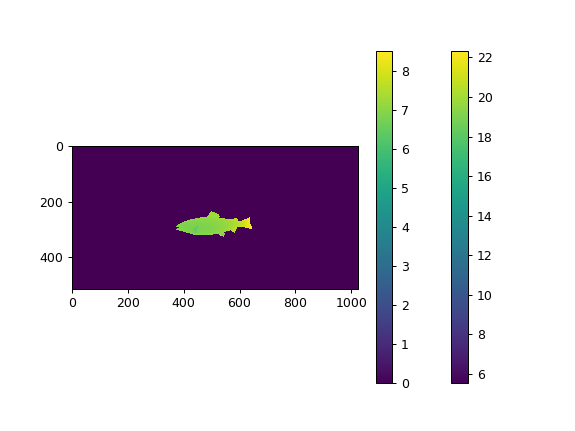

In [7]:
plt.imshow(mask)
plt.show()
plt.imshow(ground_truth_depth)
plt.colorbar()
plt.show()
plt.imshow(mdepth)
plt.colorbar()
plt.show()

In [8]:
true_length = compute_length(mask, ground_truth_depth)
print('True length: {}'.format(true_length))

True length: 6.68601874336


### 2 - Mask perturbations

#### 2.1 - Mask erosion

<IPython.core.display.Javascript object>


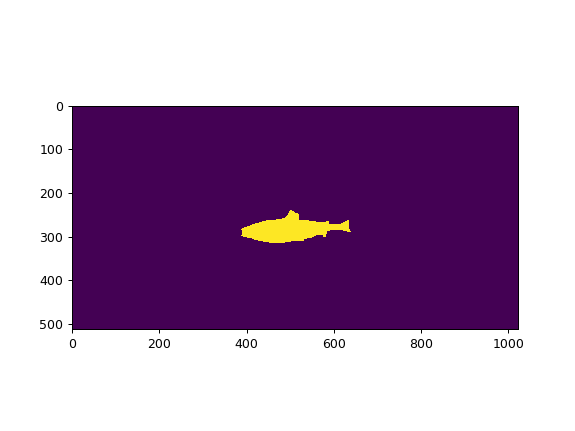

In [9]:
lengths = []
errors = []
for s in range(0, 11):
    if s > 0:
        kernel = np.ones((s, s))
        eroded_mask = cv2.erode(mask, kernel)
    else:
        eroded_mask = mask
    plt.imshow(eroded_mask)
    plt.show()
    segmentation_error = compute_segmentation_error(eroded_mask, mask)
    errors.append(segmentation_error)
    pred_length = compute_length(eroded_mask, ground_truth_depth)
    relative_error = np.abs(pred_length- true_length) / true_length
    lengths.append(relative_error)

<IPython.core.display.Javascript object>


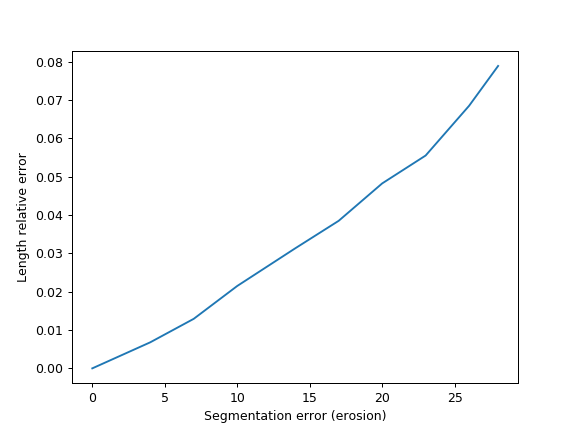

In [10]:
plt.plot(errors, lengths)
plt.xlabel('Segmentation error (erosion)')
plt.ylabel('Length relative error')
plt.show()

#### 2.2 - Mask dilatation

<IPython.core.display.Javascript object>


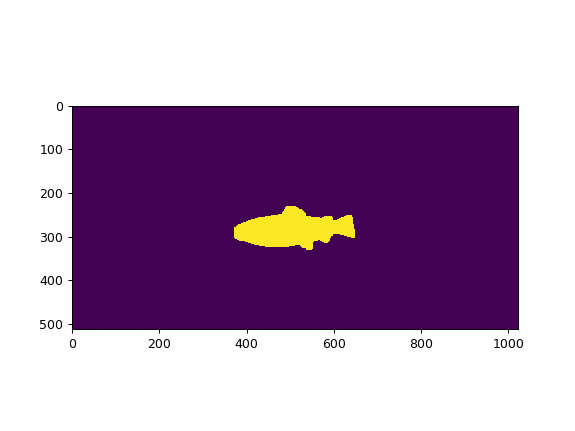

pred length : 6.68601874336, ground truth: 6.68601874336
pred length : 6.68601874336, ground truth: 6.68601874336
pred length : 13.0958925975, ground truth: 6.68601874336
pred length : 13.0203471353, ground truth: 6.68601874336
pred length : 12.0287001261, ground truth: 6.68601874336
pred length : 11.2028622061, ground truth: 6.68601874336
pred length : 11.304525065, ground truth: 6.68601874336
pred length : 10.9054644724, ground truth: 6.68601874336
pred length : 11.0918077874, ground truth: 6.68601874336
pred length : 10.8260688092, ground truth: 6.68601874336
pred length : 11.0096352563, ground truth: 6.68601874336


In [11]:
lengths = []
errors = []
for s in range(0, 11):
    if s > 0:
        kernel = np.ones((s, s))
        dilated_mask = cv2.dilate(mask, kernel)
    else:
        dilated_mask = mask
    plt.imshow(dilated_mask)
    plt.show()
    segmentation_error = compute_segmentation_error(dilated_mask, mask)
    errors.append(segmentation_error)
    pred_length = compute_length(dilated_mask, ground_truth_depth)
    relative_error = np.abs(pred_length - true_length) / true_length
    print('pred length : {}, ground truth: {}'.format(pred_length, true_length))
    lengths.append(relative_error)

<IPython.core.display.Javascript object>


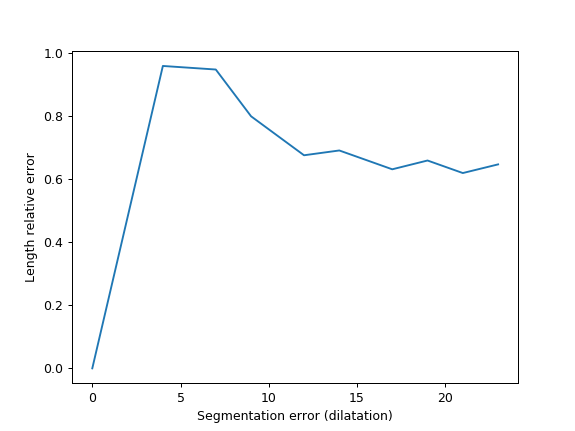

In [12]:
plt.plot(errors, lengths)
plt.xlabel('Segmentation error (dilatation)')
plt.ylabel('Length relative error')
plt.show()

### 3 - Depth map perturbations

#### 3.1 -  Same noise per pixel of the fish - translation of the depth map

0


<IPython.core.display.Javascript object>


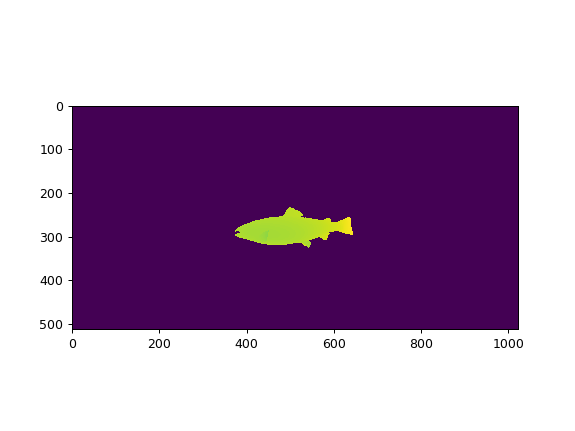

pred length : 6.68601874336, ground truth: 6.68601874336
1
gaussian nosie: 0.4
pred length : 7.01534780755, ground truth: 6.68601874336
2
gaussian nosie: 0.8


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


pred length : 7.34529318996, ground truth: 6.68601874336
3
gaussian nosie: 1.2
pred length : 7.67577778192, ground truth: 6.68601874336
4
gaussian nosie: 1.6
pred length : 8.00673653306, ground truth: 6.68601874336
5
gaussian nosie: 2.0
pred length : 8.3381142409, ground truth: 6.68601874336
6
gaussian nosie: 2.4
pred length : 8.66986379625, ground truth: 6.68601874336
7
gaussian nosie: 2.8
pred length : 9.00194478179, ground truth: 6.68601874336
8
gaussian nosie: 3.2
pred length : 9.33432234569, ground truth: 6.68601874336
9
gaussian nosie: 3.6
pred length : 9.66696629095, ground truth: 6.68601874336
10
gaussian nosie: 4.0
pred length : 9.99985033477, ground truth: 6.68601874336


In [14]:
lengths = []
errors = []
for s in range(0, 11):
    print(s)
    new_depth = copy.deepcopy(mdepth)
    if s > 0:
        noise = np.ones(new_depth.shape) * (s * 0.4)
        print('gaussian nosie: {}'.format(float(np.unique(noise))))
        new_depth += noise * mask
    plt.imshow(new_depth)
    plt.show()
    depth_relative_error = np.nanmean(np.abs(new_depth*mask-mdepth) / mdepth)
    errors.append(depth_relative_error)
    pred_length = compute_length(mask, new_depth)
    relative_error = np.abs(pred_length - true_length) / true_length
    print('pred length : {}, ground truth: {}'.format(pred_length, true_length))
    lengths.append(relative_error)

<IPython.core.display.Javascript object>


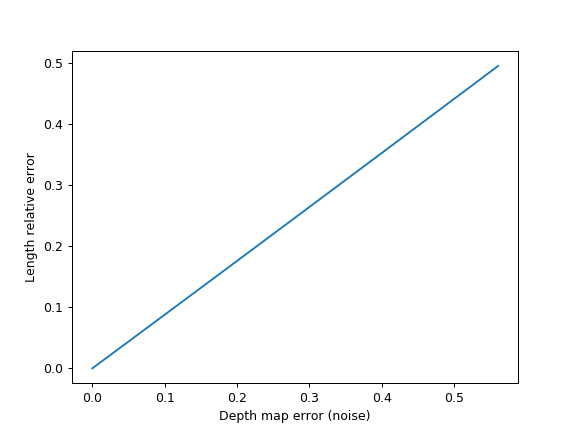

In [15]:
plt.plot(errors, lengths)
plt.xlabel('Depth map error (noise)')
plt.ylabel('Length relative error')
plt.show()

<IPython.core.display.Javascript object>


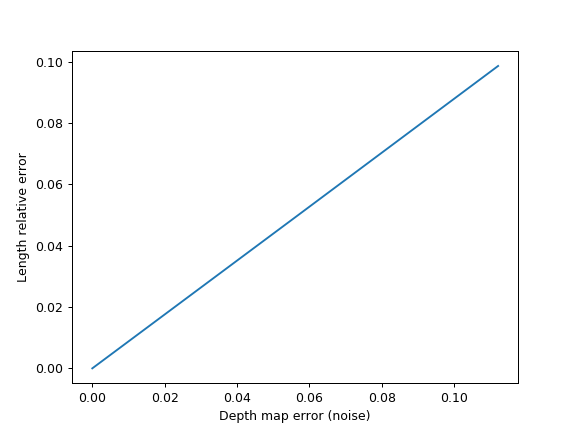

In [16]:
plt.plot(errors[:3], lengths[:3])
plt.xlabel('Depth map error (noise)')
plt.ylabel('Length relative error')
plt.show()

#### 3.2 -  Different Gaussian noise per pixel of the fish

0


<IPython.core.display.Javascript object>


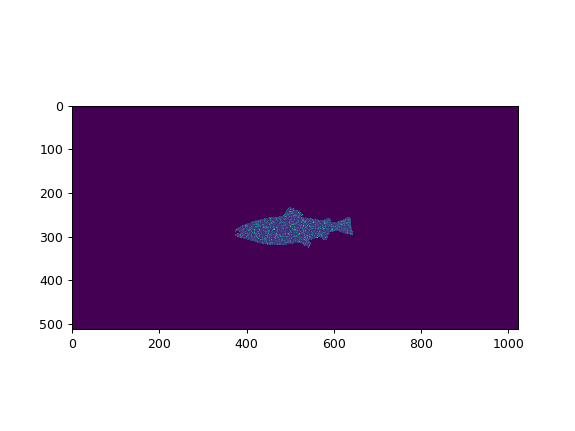

pred length : 6.68601874336, ground truth: 6.68601874336
1
pred length : 8.67698592954, ground truth: 6.68601874336
2


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


pred length : 10.522331661, ground truth: 6.68601874336
3
pred length : 14.0438857601, ground truth: 6.68601874336
4
pred length : 18.520510774, ground truth: 6.68601874336
5
pred length : 21.5781736285, ground truth: 6.68601874336
6
pred length : 22.5289284478, ground truth: 6.68601874336
7
pred length : 28.1312149631, ground truth: 6.68601874336
8
pred length : 38.6964166116, ground truth: 6.68601874336
9
pred length : 38.7379283069, ground truth: 6.68601874336
10
pred length : 43.3311549454, ground truth: 6.68601874336


In [17]:
lengths = []
errors = []
for s in range(0, 11):
    print(s)
    new_depth = copy.deepcopy(mdepth)
    if s > 0:
        noise = np.zeros(new_depth.shape, np.uint8)
        cv2.randn(noise, np.array(0), np.ones(1) * s)
        new_depth += noise * mask
    plt.imshow(new_depth)
    plt.show()
    depth_relative_error = np.nanmean(np.abs(new_depth*mask-mdepth) / mdepth)
    errors.append(depth_relative_error)
    pred_length = compute_length(mask, new_depth)
    relative_error = np.abs(pred_length - true_length) / true_length
    print('pred length : {}, ground truth: {}'.format(pred_length, true_length))
    lengths.append(relative_error)

<IPython.core.display.Javascript object>


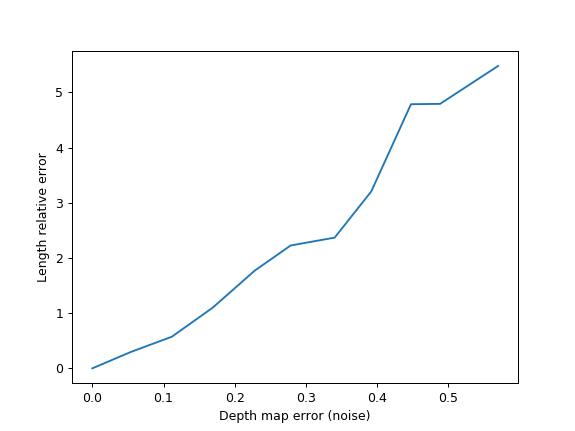

In [18]:
plt.plot(errors, lengths)
plt.xlabel('Depth map error (noise)')
plt.ylabel('Length relative error')
plt.show()

#### 3.3 - Different Gaussian noise per region of the fish

In [19]:
from error_analysor import computes_noised_sliced_dmap, get_bb_from_mask

In [20]:
nb_of_regions = 50

pred length : 6.68601874336, ground truth: 6.68601874336
(643, 374, 5)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


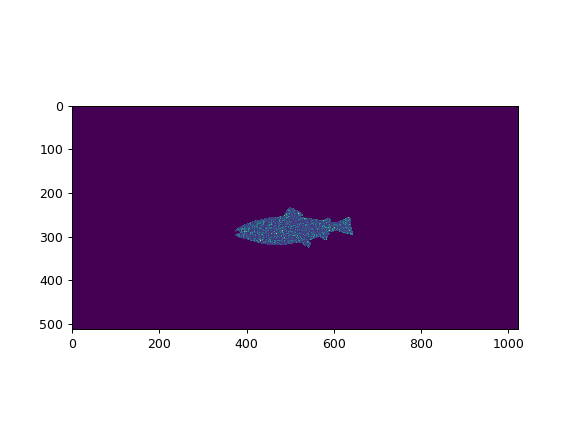

pred length : 8.65090500932, ground truth: 6.68601874336
(643, 374, 5)
pred length : 11.0308072582, ground truth: 6.68601874336
(643, 374, 5)
pred length : 13.5017769377, ground truth: 6.68601874336
(643, 374, 5)
pred length : 16.802734183, ground truth: 6.68601874336
(643, 374, 5)
pred length : 21.8341286603, ground truth: 6.68601874336
(643, 374, 5)
pred length : 25.2348867638, ground truth: 6.68601874336
(643, 374, 5)
pred length : 32.1608211597, ground truth: 6.68601874336
(643, 374, 5)
pred length : 33.6232105132, ground truth: 6.68601874336
(643, 374, 5)
pred length : 36.7972840952, ground truth: 6.68601874336
(643, 374, 5)
pred length : 36.9207292281, ground truth: 6.68601874336


In [21]:
x1, y1, x2, y2 = get_bb_from_mask(mask)
lengths = []
errors = []
for s in range(0, 11):
    new_depth = copy.deepcopy(mdepth)
    if s > 0.0:
        new_depth = computes_noised_sliced_dmap(new_depth, mask, x1, x2, s, nb_of_regions)
        plt.imshow(new_depth)
        plt.show()
    depth_relative_error = np.nanmean(np.abs(new_depth * mask - mdepth) / mdepth)
    errors.append(depth_relative_error)
    pred_length = compute_length(mask, new_depth)
    relative_error = np.abs(pred_length - true_length) / true_length
    print('pred length : {}, ground truth: {}'.format(pred_length, true_length))
    lengths.append(relative_error)

<IPython.core.display.Javascript object>


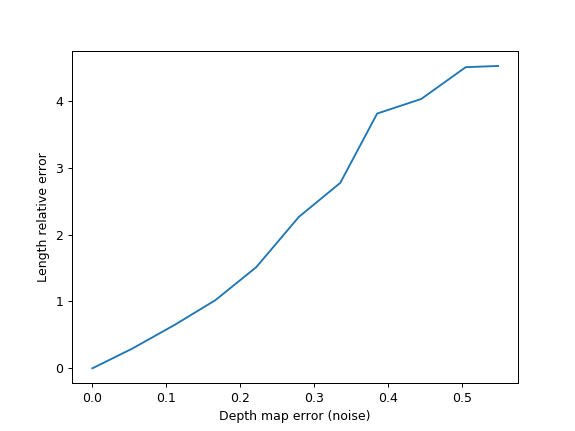

In [22]:
plt.plot(errors, lengths)
plt.xlabel('Depth map error (noise)')
plt.ylabel('Length relative error')
plt.show()

#### 3.4 - Different Gaussian noise per region of the fish & noise to background

<IPython.core.display.Javascript object>


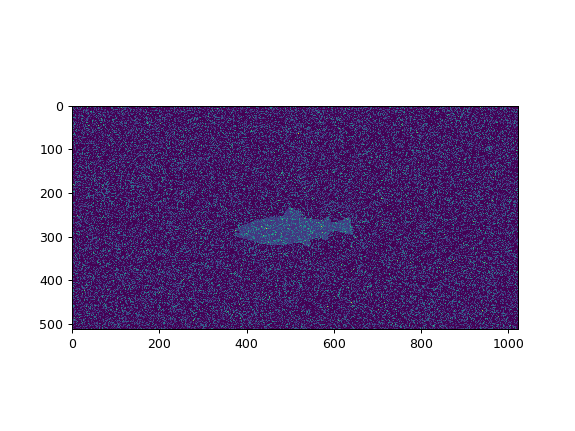

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


pred length : 6.68601874336, ground truth: 6.68601874336
(643, 374, 5)
pred length : 8.35411561263, ground truth: 6.68601874336
(643, 374, 5)
pred length : 10.2870018551, ground truth: 6.68601874336
(643, 374, 5)
pred length : 14.3576840858, ground truth: 6.68601874336
(643, 374, 5)
pred length : 16.2389695798, ground truth: 6.68601874336
(643, 374, 5)
pred length : 21.4261728751, ground truth: 6.68601874336
(643, 374, 5)
pred length : 23.0769813929, ground truth: 6.68601874336
(643, 374, 5)
pred length : 27.9601848244, ground truth: 6.68601874336
(643, 374, 5)
pred length : 29.7424103919, ground truth: 6.68601874336
(643, 374, 5)
pred length : 33.9645868823, ground truth: 6.68601874336
(643, 374, 5)
pred length : 37.7094136758, ground truth: 6.68601874336


In [23]:
x1, y1, x2, y2 = get_bb_from_mask(mask)
lengths = []
errors = []
background = np.where(mask==0)
for s in range(0, 11):
    new_depth = copy.deepcopy(mdepth)
    if s > 0.0:
        new_depth = computes_noised_sliced_dmap(new_depth, mask, x1, x2, s, nb_of_regions)
        noise = np.zeros(new_depth.shape, np.uint8)
        cv2.randn(noise, np.array(0), np.ones(1)*s)
        new_depth[background[0], background[1]] += noise[background[0], background[1]]
    plt.imshow(new_depth)
    plt.show()
    depth_relative_error = np.nanmean(np.abs(new_depth * mask - mdepth) / mdepth)
    errors.append(depth_relative_error)
    pred_length = compute_length(mask, new_depth)
    relative_error = np.abs(pred_length - true_length) / true_length
    print('pred length : {}, ground truth: {}'.format(pred_length, true_length))
    lengths.append(relative_error)

<IPython.core.display.Javascript object>


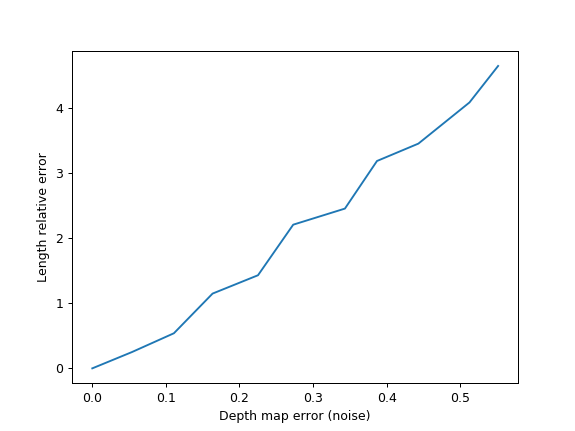

In [24]:
plt.plot(errors, lengths)
plt.xlabel('Depth map error (noise)')
plt.ylabel('Length relative error')
plt.show()

<IPython.core.display.Javascript object>


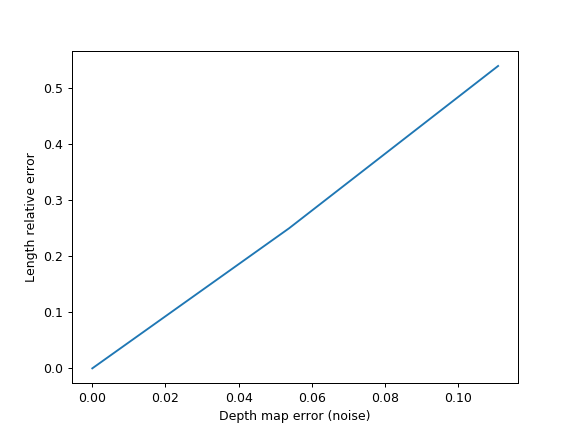

In [25]:
plt.plot(errors[:3], lengths[:3])
plt.xlabel('Depth map error (noise)')
plt.ylabel('Length relative error')
plt.show()

### 4 - Everything together

From the visualisation and if we look at the prediction of our models we can see that dilatation is more realistic than erosion. 
Regarding the noise for the depth map, noise per region with noise added to the background is obviously better.

#### 4.1 - Dilatation + Translation of dmap on fish

After the discussion with Bryton, this will be our reference

#### Create heatmap

In [33]:
lengths = np.zeros((44, 44))
errors_mask = []
errors_depth = []
all_masks = []
all_depth = []

for size in range(0, 44):
    if size > 0:
        kernel = np.ones((size, size))
        new_mask = cv2.dilate(mask, kernel)
    else:
        new_mask = mask
            
    total = new_mask + mask
    intersection = np.count_nonzero(total[total==2])
    union = np.count_nonzero(total[total>0])
    iou = intersection*100 / union
    #print('Intersection over Union: {}'.format(intersection/float(union)))
    print('Segmentation Error: {}'.format(1 - intersection/float(union)))
    errors_mask.append(100 - iou)
    all_masks.append(new_mask)
    
for s in range(0, 44):

    new_depth = copy.deepcopy(mdepth)
    if s > 0:
        noise = np.ones(new_depth.shape) * (s * 0.1)
        #print('gaussian nosie: {}'.format(float(np.unique(noise))))
        new_depth += noise * mask
        
    all_depth.append(new_depth)
    depth_relative_error = np.nanmean(np.abs(new_depth*mask-mdepth) / mdepth)
    print('Depth error : {}'.format(depth_relative_error))
    errors_depth.append(depth_relative_error*100)
    
for (i,new_mask) in enumerate(all_masks):
    for (j, new_depth) in enumerate(all_depth):
        pred_length = compute_length(new_mask, new_depth)
        relative_error = np.abs(pred_length-true_length) / true_length
        #print('Relative error {}'.format(relative_error))
        lengths[j, i] = relative_error*100

Segmentation Error: 0.0
Segmentation Error: 0.0
Segmentation Error: 0.0330452465684
Segmentation Error: 0.0627243928194
Segmentation Error: 0.0898899446305
Segmentation Error: 0.115348837209
Segmentation Error: 0.139143928618
Segmentation Error: 0.161534101644
Segmentation Error: 0.182789098944
Segmentation Error: 0.203088525768
Segmentation Error: 0.222449337149
Segmentation Error: 0.240935005701
Segmentation Error: 0.258603407952
Segmentation Error: 0.275546849494
Segmentation Error: 0.291770838874
Segmentation Error: 0.30732011862
Segmentation Error: 0.32223579719
Segmentation Error: 0.336555710584
Segmentation Error: 0.350346442861
Segmentation Error: 0.363605946178
Segmentation Error: 0.376364232517
Segmentation Error: 0.388677166077
Segmentation Error: 0.40056728648
Segmentation Error: 0.411951768915
Segmentation Error: 0.422911880716
Segmentation Error: 0.433519125218
Segmentation Error: 0.44376671123
Segmentation Error: 0.453672548215
Segmentation Error: 0.463253376335
Segmenta

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in divide


Depth error : 0.294337374899
Depth error : 0.308353440371
Depth error : 0.322369505842
Depth error : 0.336385571313
Depth error : 0.350401636785
Depth error : 0.364417702256
Depth error : 0.378433767728
Depth error : 0.392449833199
Depth error : 0.40646589867
Depth error : 0.420481964142
Depth error : 0.434498029613
Depth error : 0.448514095084
Depth error : 0.462530160556
Depth error : 0.476546226027
Depth error : 0.490562291499
Depth error : 0.50457835697
Depth error : 0.518594422441
Depth error : 0.532610487913
Depth error : 0.546626553384
Depth error : 0.560642618856
Depth error : 0.574658684327
Depth error : 0.588674749798
Depth error : 0.60269081527
Relative error 0.0
Relative error 0.012304742815
Relative error 0.0246158643076
Relative error 0.036933145663
Relative error 0.0492563776486
Relative error 0.0615853601142
Relative error 0.0739199015223
Relative error 0.0862598185052
Relative error 0.0986049354489
Relative error 0.1109550841
Relative error 0.123310103199
Relative erro

Relative error 0.420967112427
Relative error 0.433406365937
Relative error 0.445847919669
Relative error 0.458291715404
Relative error 0.470737696847
Relative error 0.483185809547
Relative error 0.495636000827
Relative error 0.50808821971
Relative error 0.520542416852
Relative error 0.532998544479
Relative error 0.0
Relative error 0.012304742815
Relative error 0.0246158643076
Relative error 0.036933145663
Relative error 0.0492563776486
Relative error 0.0615853601142
Relative error 0.0739199015223
Relative error 0.0862598185052
Relative error 0.0986049354489
Relative error 0.1109550841
Relative error 0.123310103199
Relative error 0.135669838126
Relative error 0.148034140578
Relative error 0.160402868258
Relative error 0.172775884579
Relative error 0.185153058392
Relative error 0.197534263722
Relative error 0.209919379526
Relative error 0.222308289456
Relative error 0.23470088164
Relative error 0.247097048476
Relative error 0.259496686431
Relative error 0.271899695858
Relative error 0.28

Relative error 0.0246158643076
Relative error 0.036933145663
Relative error 0.0492563776486
Relative error 0.0615853601142
Relative error 0.0739199015223
Relative error 0.0862598185052
Relative error 0.0986049354489
Relative error 0.1109550841
Relative error 0.123310103199
Relative error 0.135669838126
Relative error 0.148034140578
Relative error 0.160402868258
Relative error 0.172775884579
Relative error 0.185153058392
Relative error 0.197534263722
Relative error 0.209919379526
Relative error 0.222308289456
Relative error 0.23470088164
Relative error 0.247097048476
Relative error 0.259496686431
Relative error 0.271899695858
Relative error 0.284305980819
Relative error 0.296715448916
Relative error 0.309128011133
Relative error 0.321543581688
Relative error 0.333962077886
Relative error 0.346383419989
Relative error 0.358807531083
Relative error 0.371234336959
Relative error 0.383663765996
Relative error 0.396095749053
Relative error 0.408530219361
Relative error 0.420967112427
Relativ

Relative error 0.172775884579
Relative error 0.185153058392
Relative error 0.197534263722
Relative error 0.209919379526
Relative error 0.222308289456
Relative error 0.23470088164
Relative error 0.247097048476
Relative error 0.259496686431
Relative error 0.271899695858
Relative error 0.284305980819
Relative error 0.296715448916
Relative error 0.309128011133
Relative error 0.321543581688
Relative error 0.333962077886
Relative error 0.346383419989
Relative error 0.358807531083
Relative error 0.371234336959
Relative error 0.383663765996
Relative error 0.396095749053
Relative error 0.408530219361
Relative error 0.420967112427
Relative error 0.433406365937
Relative error 0.445847919669
Relative error 0.458291715404
Relative error 0.470737696847
Relative error 0.483185809547
Relative error 0.495636000827
Relative error 0.50808821971
Relative error 0.520542416852
Relative error 0.532998544479
Relative error 0.0
Relative error 0.012304742815
Relative error 0.0246158643076
Relative error 0.03693

Relative error 0.321543581688
Relative error 0.333962077886
Relative error 0.346383419989
Relative error 0.358807531083
Relative error 0.371234336959
Relative error 0.383663765996
Relative error 0.396095749053
Relative error 0.408530219361
Relative error 0.420967112427
Relative error 0.433406365937
Relative error 0.445847919669
Relative error 0.458291715404
Relative error 0.470737696847
Relative error 0.483185809547
Relative error 0.495636000827
Relative error 0.50808821971
Relative error 0.520542416852
Relative error 0.532998544479
Relative error 0.0
Relative error 0.012304742815
Relative error 0.0246158643076
Relative error 0.036933145663
Relative error 0.0492563776486
Relative error 0.0615853601142
Relative error 0.0739199015223
Relative error 0.0862598185052
Relative error 0.0986049354489
Relative error 0.1109550841
Relative error 0.123310103199
Relative error 0.135669838126
Relative error 0.148034140578
Relative error 0.160402868258
Relative error 0.172775884579
Relative error 0.1

Relative error 0.470737696847
Relative error 0.483185809547
Relative error 0.495636000827
Relative error 0.50808821971
Relative error 0.520542416852
Relative error 0.532998544479
Relative error 0.0
Relative error 0.012304742815
Relative error 0.0246158643076
Relative error 0.036933145663
Relative error 0.0492563776486
Relative error 0.0615853601142
Relative error 0.0739199015223
Relative error 0.0862598185052
Relative error 0.0986049354489
Relative error 0.1109550841
Relative error 0.123310103199
Relative error 0.135669838126
Relative error 0.148034140578
Relative error 0.160402868258
Relative error 0.172775884579
Relative error 0.185153058392
Relative error 0.197534263722
Relative error 0.209919379526
Relative error 0.222308289456
Relative error 0.23470088164
Relative error 0.247097048476
Relative error 0.259496686431
Relative error 0.271899695858
Relative error 0.284305980819
Relative error 0.296715448916
Relative error 0.309128011133
Relative error 0.321543581688
Relative error 0.33

Relative error 0.0739199015223
Relative error 0.0862598185052
Relative error 0.0986049354489
Relative error 0.1109550841
Relative error 0.123310103199
Relative error 0.135669838126
Relative error 0.148034140578
Relative error 0.160402868258
Relative error 0.172775884579
Relative error 0.185153058392
Relative error 0.197534263722
Relative error 0.209919379526
Relative error 0.222308289456
Relative error 0.23470088164
Relative error 0.247097048476
Relative error 0.259496686431
Relative error 0.271899695858
Relative error 0.284305980819
Relative error 0.296715448916
Relative error 0.309128011133
Relative error 0.321543581688
Relative error 0.333962077886
Relative error 0.346383419989
Relative error 0.358807531083
Relative error 0.371234336959
Relative error 0.383663765996
Relative error 0.396095749053
Relative error 0.408530219361
Relative error 0.420967112427
Relative error 0.433406365937
Relative error 0.445847919669
Relative error 0.458291715404
Relative error 0.470737696847
Relative e

Relative error 0.222308289456
Relative error 0.23470088164
Relative error 0.247097048476
Relative error 0.259496686431
Relative error 0.271899695858
Relative error 0.284305980819
Relative error 0.296715448916
Relative error 0.309128011133
Relative error 0.321543581688
Relative error 0.333962077886
Relative error 0.346383419989
Relative error 0.358807531083
Relative error 0.371234336959
Relative error 0.383663765996
Relative error 0.396095749053
Relative error 0.408530219361
Relative error 0.420967112427
Relative error 0.433406365937
Relative error 0.445847919669
Relative error 0.458291715404
Relative error 0.470737696847
Relative error 0.483185809547
Relative error 0.495636000827
Relative error 0.50808821971
Relative error 0.520542416852
Relative error 0.532998544479


<IPython.core.display.Javascript object>


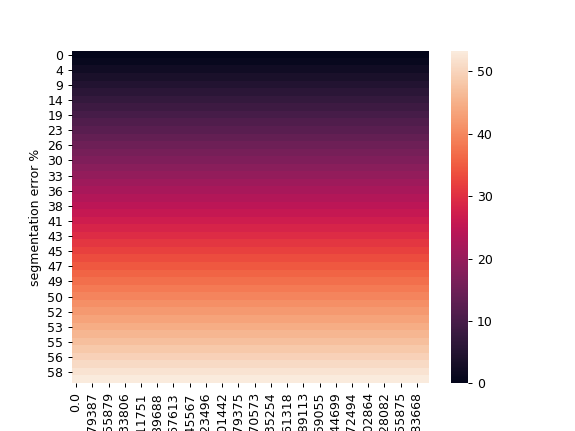

Text(0.5,23.5222,'depth map error %')

In [36]:
df = pd.DataFrame(lengths, index=errors_mask, columns=errors_depth)
ax = sns.heatmap(df)
ax.set_ylabel('segmentation error %')
ax.set_xlabel('depth map error %')

#### Filter heatmap given target_error

In [37]:
target_error = 40

<IPython.core.display.Javascript object>


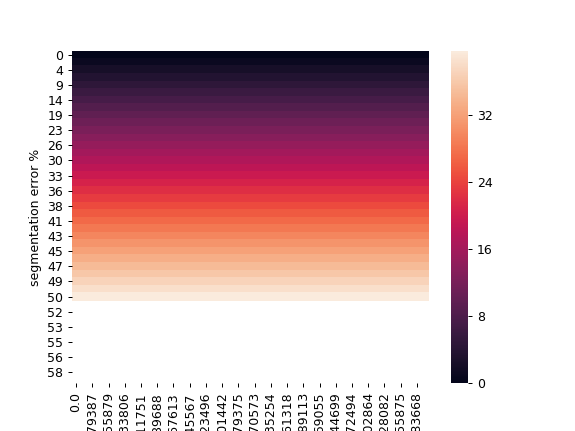

In [38]:
ax = sns.heatmap(df[df < 40])
ax.set_ylabel('segmentation error %')
ax.set_xlabel('depth map error %')
ax.set_title = 'Filtered heat map : {}'.format(target_error)

#### 4.2 - Dilatation + Noise on fish

#### Create heatmap

In [45]:
lengths = np.zeros((44, 44))
errors_mask = []
errors_depth = []
all_masks = []
all_depth = []

for size in range(0, 44):
    if size > 0:
        kernel = np.ones((size, size))
        new_mask = cv2.dilate(mask, kernel)
    else:
        new_mask = mask
            
    total = new_mask + mask
    intersection = np.count_nonzero(total[total==2])
    union = np.count_nonzero(total[total>0])
    iou = intersection * 100 / union
    # print('Intersection over Union: {}'.format(intersection/float(union)))
    print('Segmentation Error: {}'.format(1 - intersection/float(union)))
    errors_mask.append(100 - iou)
    all_masks.append(new_mask)
    
for s in range(0, 44):
    
    new_depth = copy.deepcopy(mdepth)
    if s > 0:
        # creat some noise
        noise = np.zeros((512, 1024), np.uint8)
        cv2.randn(noise, np.array(0), np.ones(1)*s*0.2)
        new_depth += noise
        
    all_depth.append(new_depth)
    depth_relative_error = np.nanmean(np.abs(new_depth*mask-mdepth) / mdepth)
    print('Depth error: {}'.format(depth_relative_error))
    errors_depth.append(depth_relative_error*100)
    
for (i,new_mask) in enumerate(all_masks):
    for (j, new_depth) in enumerate(all_depth):
        pred_length = compute_length(new_mask, new_depth)
        relative_error = np.abs(pred_length-true_length) / true_length
        #print('Length error : {}'.format(relative_error))
        lengths[j, i] = relative_error*100

Segmentation Error: 0.0
Segmentation Error: 0.0
Segmentation Error: 0.0330452465684
Segmentation Error: 0.0627243928194
Segmentation Error: 0.0898899446305
Segmentation Error: 0.115348837209
Segmentation Error: 0.139143928618
Segmentation Error: 0.161534101644
Segmentation Error: 0.182789098944
Segmentation Error: 0.203088525768
Segmentation Error: 0.222449337149
Segmentation Error: 0.240935005701
Segmentation Error: 0.258603407952
Segmentation Error: 0.275546849494
Segmentation Error: 0.291770838874
Segmentation Error: 0.30732011862
Segmentation Error: 0.32223579719
Segmentation Error: 0.336555710584
Segmentation Error: 0.350346442861
Segmentation Error: 0.363605946178
Segmentation Error: 0.376364232517
Segmentation Error: 0.388677166077
Segmentation Error: 0.40056728648
Segmentation Error: 0.411951768915
Segmentation Error: 0.422911880716
Segmentation Error: 0.433519125218
Segmentation Error: 0.44376671123
Segmentation Error: 0.453672548215
Segmentation Error: 0.463253376335
Segmenta

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in divide


Depth error: 0.164698540667
Depth error: 0.179710225336
Depth error: 0.187163853505
Depth error: 0.200370555873
Depth error: 0.213140356485
Depth error: 0.222256632669
Depth error: 0.237650594697
Depth error: 0.245675710177
Depth error: 0.252572538475
Depth error: 0.265297267866
Depth error: 0.277917735384
Depth error: 0.28605185646
Depth error: 0.30396143843
Depth error: 0.314723390171
Depth error: 0.321977710428
Depth error: 0.341163430467
Depth error: 0.34672327492
Depth error: 0.359064508118
Depth error: 0.367455084546
Depth error: 0.38082530548
Depth error: 0.396675378206
Depth error: 0.406353937623
Depth error: 0.410415425241
Depth error: 0.42400012676
Depth error: 0.432502731851
Depth error: 0.446185794543
Depth error: 0.453652047447
Depth error: 0.469889797471
Depth error: 0.482443369971


<IPython.core.display.Javascript object>


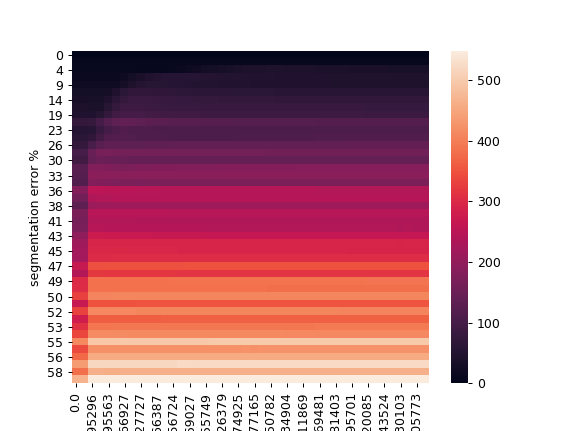

Text(0.5,23.5222,'depth map error %')

In [46]:
df = pd.DataFrame(lengths, index=errors_mask, columns=errors_depth)
ax = sns.heatmap(df)
ax.set_ylabel('segmentation error %')
ax.set_xlabel('depth map error %')

#### Filter heatmap given target error

In [47]:
target_error = 40

<IPython.core.display.Javascript object>


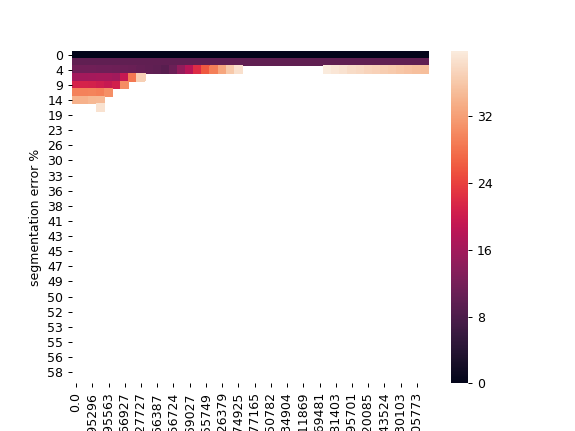

In [48]:
ax = sns.heatmap(df[df < 40])
ax.set_ylabel('segmentation error %')
ax.set_xlabel('depth map error %')
ax.set_title = 'Filtered heat map : {}'.format(target_error)

#### 4.2 - Dilatation + Noise per region

#### Create heatmap

In [49]:
lengths = np.zeros((11, 11))
errors_mask = []
errors_depth = []
all_masks = []
all_depth = []

for size in range(0, 11):
    if size > 0:
        kernel = np.ones((size, size))
        new_mask = cv2.dilate(mask, kernel)
    else:
        new_mask = mask
            
    total = new_mask + mask
    intersection = np.count_nonzero(total[total==2])
    union = np.count_nonzero(total[total>0])
    iou = intersection*100 / union
    print('Segmentation error: {}'.format(1 - intersection/float(union)))
    errors_mask.append(100 - iou)
    all_masks.append(new_mask)
    
for s in range(0, 11):
    new_depth = copy.deepcopy(mdepth)
    if s > 0.0:
        new_depth = computes_noised_sliced_dmap(new_depth, mask, x1, x2, s, nb_of_regions)
    all_depth.append(new_depth)
    depth_relative_error = np.nanmean(np.abs(new_depth*mask-mdepth) / mdepth)
    print('Depth map error: {}'.format(depth_relative_error))
    errors_depth.append(depth_relative_error*100)
    
for (i,new_mask) in enumerate(all_masks):
    for (j, new_depth) in enumerate(all_depth):
        pred_length = compute_length(new_mask, new_depth)
        relative_error = np.abs(pred_length-true_length) / true_length
        lengths[j, i] = relative_error*100

Segmentation error: 0.0
Segmentation error: 0.0
Segmentation error: 0.0330452465684
Segmentation error: 0.0627243928194
Segmentation error: 0.0898899446305
Segmentation error: 0.115348837209
Segmentation error: 0.139143928618
Segmentation error: 0.161534101644
Segmentation error: 0.182789098944
Segmentation error: 0.203088525768
Segmentation error: 0.222449337149
Depth map error: 0.0
(643, 374, 5)
Depth map error: 0.0545170837598
(643, 374, 5)
Depth map error: 0.111444593791
(643, 374, 5)
Depth map error: 0.16504751096
(643, 374, 5)
Depth map error: 0.223840077219
(643, 374, 5)
Depth map error: 0.28026755089
(643, 374, 5)
Depth map error: 0.342030886567
(643, 374, 5)
Depth map error: 0.394906992317
(643, 374, 5)
Depth map error: 0.455765239862
(643, 374, 5)
Depth map error: 0.501882569364
(643, 374, 5)
Depth map error: 0.546613570541


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


In [50]:
df = pd.DataFrame(lengths, index=errors_mask, columns=errors_depth)
ax = sns.heatmap(df)
ax.set_ylabel('segmentation error %')
ax.set_xlabel('depth map error %')

<IPython.core.display.Javascript object>

Text(0.5,23.5222,'depth map error %')

#### Filter heatmap given target error

#### 4.3 - Dilatation + Noise per region + background

In [103]:
lengths = np.zeros((11, 11))
errors_mask = []
errors_depth = []
all_masks = []
all_depth = []
background = np.where(mask==0)

for size in range(0, 11):
    if size > 0:
        kernel = np.ones((size, size))
        new_mask = cv2.dilate(mask, kernel)
    else:
        new_mask = mask
            
    total = new_mask + mask
    intersection = np.count_nonzero(total[total==2])
    union = np.count_nonzero(total[total>0])
    iou = intersection*100 / union
    # print('Intersection over Union: {}'.format(intersection/float(union)))
    # print('Error: {}'.format(1 - intersection/float(union)))
    errors_mask.append(100 - iou)
    all_masks.append(new_mask)
    
for s in range(0, 11):
    new_depth = copy.deepcopy(mdepth)
    if s > 0.0:
        new_depth = computes_noised_sliced_dmap(new_depth, mask, x1, x2, s, nb_of_regions)
        noise = np.zeros(new_depth.shape, np.uint8)
        cv2.randn(noise, np.array(0), np.ones(1)*s)
        new_depth[background[0], background[1]] += noise[background[0], background[1]]
    all_depth.append(new_depth)
    depth_relative_error = np.nanmean(np.abs(new_depth*mask-mdepth) / mdepth)
    # print(depth_relative_error)
    errors_depth.append(depth_relative_error*100)
    
for (i,new_mask) in enumerate(all_masks):
    for (j, new_depth) in enumerate(all_depth):

        # calculate ground truth length
        y, x = np.nonzero(new_depth*new_mask)
        wx, wy, wz = convert_to_world_point(x, y, new_depth)
        cloud = []
        pred_length = compute_length(new_mask, new_depth)
        
        
        # print(pred_length)
        # print('True length: {}'.format(pred_length))
        relative_error = np.abs(pred_length-true_length) / true_length
        lengths[j, i] = relative_error*100

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in divide


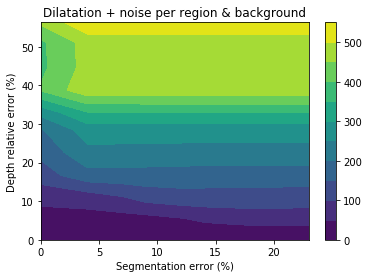

In [104]:
plt.contourf(errors_mask, errors_depth, lengths, levels=range(0, int(lengths.max())+50, 50))
plt.xlabel('Segmentation error (%)')
plt.ylabel('Depth relative error (%)')
plt.title('Dilatation + noise per region & background')
plt.colorbar()

In [106]:
np.random.normal(0, s, 1) * np.ones

array([-22.25235504])